# Lab 4 - Lab Assignment

Team Members:
- Achchala Deepan - 20943939
- Manjary Muruganandan - 20950662

Group #10

In [14]:
# Practice: Shipment Consolidation

# Step 0: import the libraries
# ----------------------------------------------------------------
import pandas as pd
from IPython.display import display
from docplex.mp.model import Model

# Step 1: import the dataframes
# ----------------------------------------------------------------
# Customer data
df_customers = pd.DataFrame({
    "Customer": [1, 2, 3],
    "Demand": [2, 3, 1],
    "ReleaseTime": [2, 3, 1],
    "DueDate": [6, 5, 4]})

# Route data
df_routes = pd.DataFrame({
    "RouteID": [1, 2],
    "Nodes": [["Factory", "C1", "C2"], ["Factory", "C2", "C3"]],
    "TravelTimes": [[1, 2], [1.5, 1]],   # segment-wise travel time
    "Cost": [6, 5]                       # fixed cost to operate
})

# Common carrier data
df_carrier = pd.DataFrame({
    "Customer": [1, 2, 3],
    "DeliveryTime": [1, 1, 1],
    "Cost": [8, 7, 9]})

# Travel time to customer on each route (k = customer, r = route)
tau_kr = {
    (1, 1): 1,    # C1 via R1
    (2, 1): 3,    # C2 via R1
    (2, 2): 1.5,  # C2 via R2
    (3, 2): 2.5}  # C3 via R2


# Which customers are on which routes
S_r = {
    1: [1, 2],   # Route 1 can serve C1, C2
    2: [2, 3]}   # Route 2 can serve C2, C3


display(df_customers)
display(df_routes)
display(df_carrier)

,Customer,Demand,ReleaseTime,DueDate
0,1,2,2,6
1,2,3,3,5
2,3,1,1,4


,RouteID,Nodes,TravelTimes,Cost
0,1,"[Factory, C1, C2]","[1, 2]",6
1,2,"[Factory, C2, C3]","[1.5, 1]",5


,Customer,DeliveryTime,Cost
0,1,1,8
1,2,1,7
2,3,1,9


In [15]:
# Step 2: Define the model and decision variable x

# we define the list based on the slides
customers = [1, 2, 3] # customer index
routes = [1, 2] # two routes, r1 and r2
capacity = 4 # truck capacity

# How to calculate the time_periods
dispatch_times = []
for (k, r) in tau_kr: # Loop over each (customer k, route r) pair that has a travel time

    due_date = df_customers.loc[k - 1, "DueDate"] # Get due date of customer k
    travel_time = tau_kr[(k, r)] # Get travel time to customer k via route r
    # Calculate the latest time the truck can leave to serve this customer
    if r in S_r and k in S_r[r]:  # Check if customer k is served by route r
        latest_time = due_date - travel_time # Compute the latest time the truck can leave to serve this customer (t ≤ dk−τkr)
    else:
        latest_time = 0 # If the customer is not served by the route, set latest_time to 0
    dispatch_times.append(latest_time)  # Add to the list
    latest_time = due_date - travel_time # Compute the latest time the truck can leave to serve this customer (t ≤ dk−τkr)
    dispatch_times.append(latest_time)  # Add to the list

latest_dispatch_time = max(dispatch_times) # Take the maximum of all valid dispatch times
time_periods = list(range(1, int(latest_dispatch_time) + 1)) # Based on the maximum of dispatch time, create the time period list (e.g., [1, 2, 3,...])
print(time_periods)

mdl = Model("CPLEX_Shipment_Consolidation")

x = mdl.binary_var_dict(((k, r, t) for k in customers for r in routes for t in time_periods), name = "x")
y = mdl.binary_var_dict(((r, t) for r in routes for t in time_periods), name = "y")
z = mdl.binary_var_dict(customers, name = "z")

[1, 2, 3, 4, 5]


In [3]:
mdl.context.solver.log_output = True
mdl.context.solver.agent = 'cloud'
# Step 3: Define the constraints
# 3-1. Capacity constraint per route and time
for r in routes:
    for t in time_periods:
        mdl.add_constraint(mdl.sum(x[k, r, t] * df_customers.loc[k - 1, "Demand"] for k in customers) <= capacity * y[r, t],
                           f"Capacity_Constraint_R{r}_T{t}")

# 3-2. Each customer is served exactly once (truck or carrier)
for k in customers:
    mdl.add_constraint(mdl.sum(x[k, r, t] for r in routes for t in time_periods) + z[k] == 1,
                       f"Customer_Served_Once_Customer{k}")

# 3-3. optional constraints
# 3-3.1. If a customer is served by a route, the route must be dispatched at some time
for r in routes:
    for k in S_r[r]:  # Only consider customers served by route r
        mdl.add_constraint(mdl.sum(x[k, r, t] for t in time_periods) <= mdl.sum(y[r, t] for t in time_periods),
                           f"Route_Dispatch_Constraint_R{r}_Customer{k}")
# 3-3.2. If a route is dispatched, at least one customer must be served
for r in routes:
    for t in time_periods:
        mdl.add_constraint(mdl.sum(x[k, r, t] for k in customers) >= y[r, t],
                           f"Route_Dispatch_AtLeastOne_Customer_R{r}_T{t}")
# 3-3.3. If a customer is served by a common carrier, it cannot be served by a truck
for k in customers:
    mdl.add_constraint(z[k] + mdl.sum(x[k, r, t] for r in routes for t in time_periods) <= 1,
                       f"Carrier_Truck_Conflict_Customer{k}")
# 3-3.4. If a customer is served by a truck, it cannot be served by a common carrier
for k in customers:
    mdl.add_constraint(z[k] + mdl.sum(x[k, r, t] for r in routes for t in time_periods) <= 1,
                       f"Truck_Carrier_Conflict_Customer{k}")

# Step 4: Objective – minimize the cost
mdl.minimize(mdl.sum(df_routes.loc[r - 1, "Cost"] * x[k, r, t] for k in customers for r in routes for t in time_periods)
             + mdl.sum(df_carrier.loc[k - 1, "Cost"] * z[k] for k in customers))
mdl.context.solver.agent = 'cloud'
# Step 5: Solve and print
solution = mdl.solve(log_output = True)

# --- Output solution ---
if solution:
    print("Objective value:", solution.objective_value)

    print("Truck Assignments (x_krt):")
    for k, r, t in x:
        if x[k, r, t].solution_value > 0.5:
            print(f"Customer {k} is served by Route {r} at time {t}; x[{k}, {r}, {t}] = 1")

    print("Route Dispatches (y_rt):")
    for r, t in y:
        if y[r, t].solution_value > 0.5:
            print(f"Route {r} is dispatched at time {t}; y[{r}, {t}] = 1")

    print("Customers served by the carrier (z_k):")
    for k in z:
        if z[k].solution_value > 0.5:
            print(f"Customer {k} is served via common carrier")
else:
    print("No feasible solution found.")

# Optional: Show the model formulation
print("\nMODEL FORMULATION:")
print(mdl.export_as_lp_string())

NameError: name 'mdl' is not defined

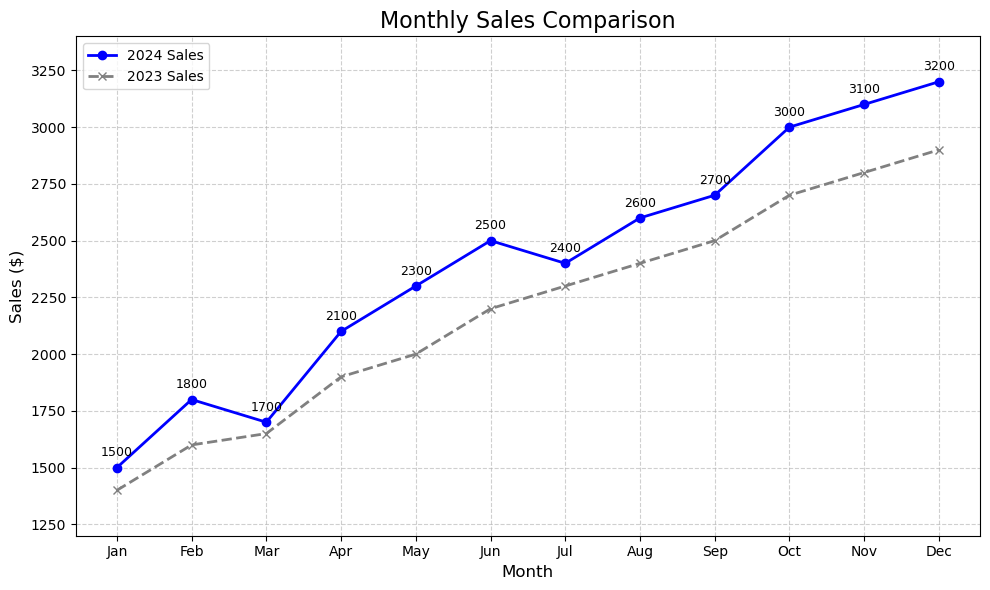

In [2]:
import matplotlib.pyplot as plt

# Monthly labels for X-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Actual sales data (e.g., this year vs last year)
sales = [1500, 1800, 1700, 2100, 2300, 2500, 2400, 2600, 2700, 3000, 3100, 3200]
sales_last_year = [1400, 1600, 1650, 1900, 2000, 2200, 2300, 2400, 2500, 2700, 2800, 2900]

# Step 0: Create a figure with specified size
plt.figure(figsize = (10, 6))

# Step 1: Plot the lines
plt.plot(months, sales, label = '2024 Sales', color = 'blue', marker = 'o', linestyle = '-', linewidth = 2)
plt.plot(months, sales_last_year, label = '2023 Sales', color = 'gray', marker = 'x', linestyle = '--', linewidth = 2)

# You can customize the line with the following options:
#   linestyle: "-" (solid), "--" (dashed), "-." (dash-dot), ":" (dotted)
#   marker: "o" (circle), "x" (x mark), "s" (square), "^" (triangle), "*" (star)
#   color: 'blue', 'gray', 'red', 'green', etc. or hex codes like '#FF5733'
# Advanced skill: use dictionary to select the style and for loop to plot it

# Step 2: Add plot title and axis labels and other options
plt.title("Monthly Sales Comparison", fontsize = 16)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Sales ($)", fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6) # Optional: Add grid for better readability
plt.legend(loc='upper left') # Optional: Add a legend in the upper left corner

# Optional: Add value annotations to the 2024 line
for i, value in enumerate(sales):
    plt.text(i, value + 50, str(value), ha = 'center', fontsize = 9)

plt.ylim(1200, 3400) # Adjust y-axis limit for better layout
plt.tight_layout() # optional: Make layout tight to avoid clipping

# Step 3: Show the final plot
plt.show()

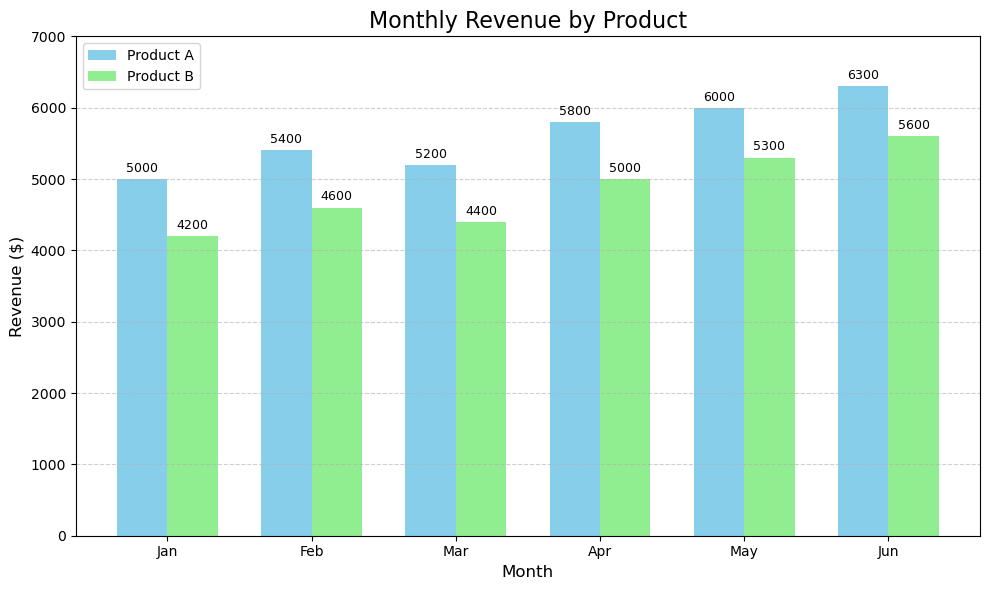

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Monthly labels for X-axis (first 6 months)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Revenue from two product categories
revenue_A = [5000, 5400, 5200, 5800, 6000, 6300]
revenue_B = [4200, 4600, 4400, 5000, 5300, 5600]

# Step 0: Create a figure with specified size
plt.figure(figsize = (10, 6))

# Step 1: Plot the grouped bar chart
bar_width = 0.35
x = np.arange(len(months))  # numeric x positions for each month

# Plot bars for each category
plt.bar(x - bar_width/2, revenue_A, width = bar_width, label = 'Product A', color = 'skyblue')
plt.bar(x + bar_width/2, revenue_B, width = bar_width, label = 'Product B', color = 'lightgreen')

# You can customize bar colors, width, edge color, or add patterns with hatch
# Advanced skill: Use a for loop or DataFrame to generate multiple product bars dynamically

# Step 2: Add plot title and axis labels and other options
plt.title("Monthly Revenue by Product", fontsize = 16)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Revenue ($)", fontsize = 12)
plt.xticks(x, months)  # Set x-axis tick labels to month names
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)  # Optional: Add horizontal gridlines
plt.legend(loc = 'upper left')  # Optional: Add a legend

# Optional: Add value annotations on top of bars
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, revenue_A[i] + 100, str(revenue_A[i]), ha = 'center', fontsize = 9)
    plt.text(x[i] + bar_width/2, revenue_B[i] + 100, str(revenue_B[i]), ha = 'center', fontsize = 9)

plt.ylim(0, 7000)  # Adjust y-axis limit
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 3: Show the final plot
plt.show()

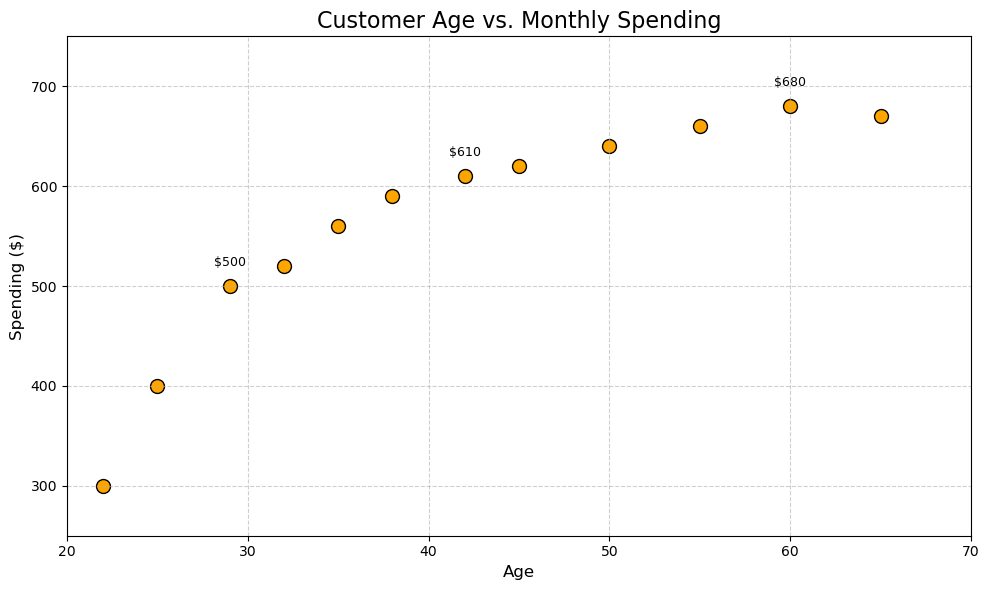

In [23]:
import matplotlib.pyplot as plt

# Step 0: Prepare data
# X: Age of customers
# Y: Monthly spending in dollars
ages = [22, 25, 29, 32, 35, 38, 42, 45, 50, 55, 60, 65]
spending = [300, 400, 500, 520, 560, 590, 610, 620, 640, 660, 680, 670]

# Step 1: Create a figure with specified size
plt.figure(figsize=(10, 6))

# Step 2: Plot the scatter points
plt.scatter(ages, spending, color = 'orange', edgecolor = 'black', s = 100)

# You can customize the scatter points with:
#   color: inside color of the dots (e.g., 'orange', 'green', '#99ccff')
#   edgecolor: outline color of each dot
#   s: size of the dots
# Advanced skill: You can use a third variable (e.g., income) to vary dot size or color dynamically

# Step 3: Add plot title and axis labels and other options
plt.title("Customer Age vs. Monthly Spending", fontsize = 16)
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Spending ($)", fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6)  # Optional: Add grid for better readability

# Optional: Add annotations for some points
highlight = [2, 6, 10]  # selected points to annotate
for i in highlight:
    plt.text(ages[i], spending[i] + 20, f"${spending[i]}", ha = 'center', fontsize = 9)

plt.xlim(20, 70)  # Set x-axis range (age)
plt.ylim(250, 750)  # Set y-axis range (spending)
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 4: Show the final plot
plt.show()

[92.64052346 79.00157208 84.78737984 97.40893199 93.6755799  65.2272212
 84.50088418 73.48642792 73.96781148 79.10598502 76.44043571 89.54273507
 82.61037725 76.21675016 79.43863233 78.33674327 89.94079073 72.94841736
 78.13067702 66.45904261 49.47010184 81.53618595 83.64436199 67.5783498
 97.69754624 60.45634325 75.45758517 73.1281615  90.32779214 89.6935877
 76.54947426 78.7816252  66.12214252 55.19203532 71.52087851 76.56348969
 87.30290681 87.02379849 71.12673183 71.97697249 64.51447035 60.79982063
 57.93729809 94.50775395 69.90347818 70.61925698 62.4720464  82.77490356
 58.86102152 72.8725972  66.04533439 78.86902498 69.89194862 63.19367816
 74.71817772 79.28331871 75.66517222 78.02471898 68.65677906 71.37258834
 68.27539552 71.40446838 66.86853718 57.73717398 76.77426142 70.98219064
 58.69801653 79.62782256 65.92701636 75.51945396 82.29090562 76.28982911
 86.39400685 62.6517418  79.02341641 68.15189909 66.29202851 69.21150335
 71.88447468 75.56165342 63.34850159 84.00826487 79.65

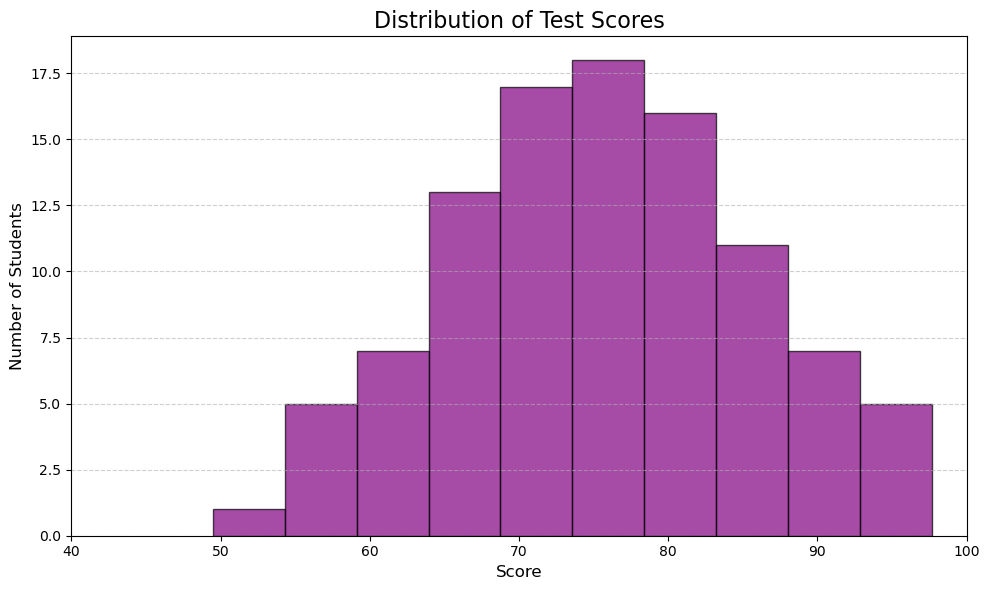

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Step 0: Generate or prepare data
# Simulated test scores (normal distribution)
np.random.seed(0)
scores = np.random.normal(loc = 75, scale = 10, size = 100)  # mean=75, std=10, 100 students
print(scores)

# Step 1: Create a figure with specified size
plt.figure(figsize=(10, 6))

# Step 2: Plot the histogram
plt.hist(scores, bins = 10, color = 'purple', edgecolor = 'black', alpha = 0.7)

# You can customize the histogram with:
#   bins: number of intervals to group the data,
#         you can use Sturges' rule, Square root rule, or Freedman-Diaconis Rule to calculate the suitable number of the bins
#   color: fill color of bars
#   edgecolor: outline color for each bin
#   alpha: transparency (0.0 = invisible, 1.0 = solid)
# Advanced skill: try plt.hist(..., density=True) to show relative frequencies

# Step 3: Add plot title and axis labels and other options
plt.title("Distribution of Test Scores", fontsize = 16)
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Number of Students", fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)  # Optional: Add horizontal grid lines

plt.xlim(40, 100)  # Optional: Set score range
plt.tight_layout()  # optional: Make layout tight to avoid clipping

# Step 4: Show the final plot
plt.show()

/Users/achchala/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


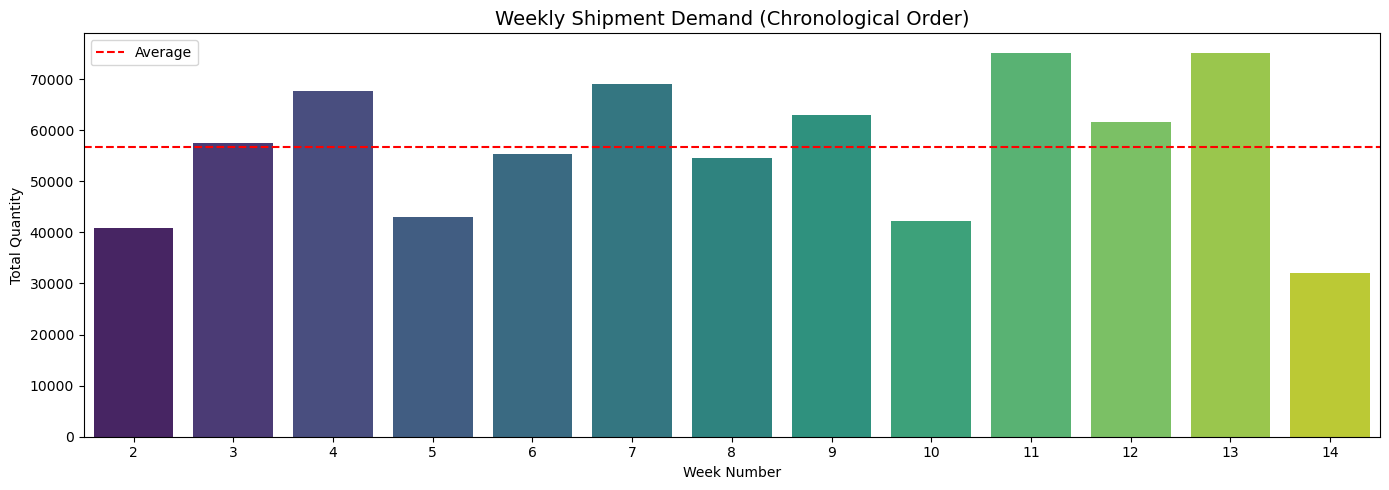

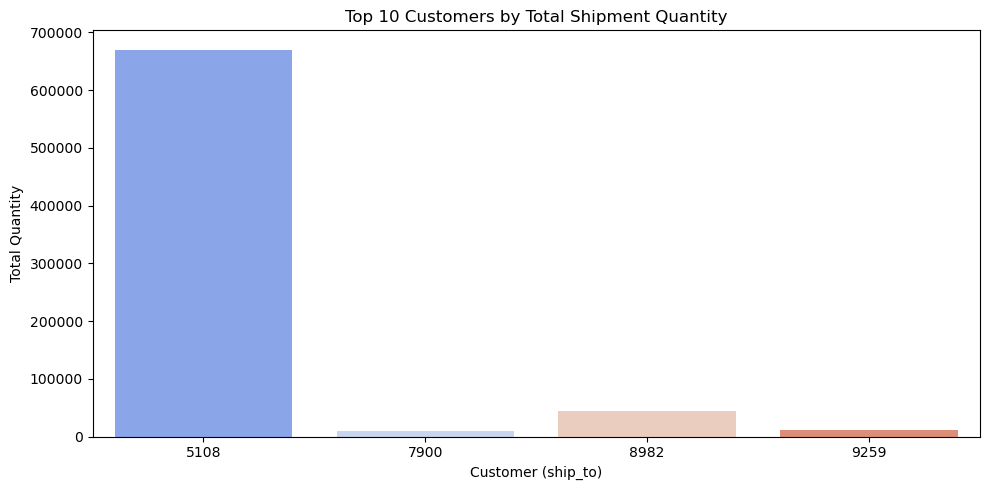

In [1]:
#Assignment:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel Data
xls = pd.ExcelFile("MS434_Lab4_Assignment_Data.xlsx")
order_df = xls.parse('Order record')

# Weekly Demand Summary
weekly_summary = order_df.groupby('req_week').agg({'Qty': 'sum'}).reset_index()
weekly_summary.columns = ['Week', 'Total Quantity']
weekly_summary = weekly_summary.sort_values(by='Week')

# Plot 1: Weekly Shipment Demand
plt.figure(figsize=(14, 5))
sns.barplot(data=weekly_summary, x='Week', y='Total Quantity', palette='viridis')
plt.axhline(y=weekly_summary['Total Quantity'].mean(), color='red', linestyle='--', label='Average')
plt.title('Weekly Shipment Demand (Chronological Order)', fontsize=14)
plt.ylabel('Total Quantity')
plt.xlabel('Week Number')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Top 10 Customers by Shipment Quantity
top_customers = order_df.groupby('ship_to').agg({'Qty': 'sum'}).reset_index()
top_customers = top_customers.sort_values(by='Qty', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_customers, x='ship_to', y='Qty', palette='coolwarm')
plt.title('Top 10 Customers by Total Shipment Quantity')
plt.xlabel('Customer (ship_to)')
plt.ylabel('Total Quantity')
plt.tight_layout()
plt.show()


### Analysis


The first figure shows weekly shipment demand from Week 2 to 14. You can see a lot of variation between weeks. Weeks 4, 7, 11, and 13 had really high volumes, while Weeks 2, 5, 10, and especially 14 were much lower than average. This kind of inconsistency makes it harder to plan shipments efficiently and could lead to underused capacity in low-demand weeks. Grouping shipments from slower weeks might help improve truck utilization.

The second figure shows the top customers by shipment quantity. One customer (5108) clearly dominates, making up the majority of the volume. The others are much smaller in comparison. This suggests that most planning effort should focus on serving that one large customer efficiently. For the smaller ones, it probably makes more sense to consolidate their orders together when possible to make the most out of each trip.